# Recomienda libros

In [1]:
# %load basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',200)
pd.options.display.float_format = '{:.2f}'.format
liga = '/home/ef/Documents/Diplomado/data/'

In [2]:
import time
start = time.time()

## Funciones

In [3]:
import re

def read_book(file_dir, pattern, encoding):
    with open(file_dir,'rb') as file:
        file = file.read().decode(encoding)
    matches = re.finditer(pattern, file, re.MULTILINE | re.VERBOSE)
    return pd.DataFrame([x.groupdict() for x in matches])

In [4]:
def outlier(df, x, p = 0.5):
    var = df[x]
    q1 = var.quantile(p/2)
    q3 = var.quantile(1 - p/2)
    iqr = q3 - q1
    df = df[(var.isnull()) | ((var >= q1 - 1.5*iqr) & (var <= q3 + 1.5*iqr))].copy()
    return df

In [5]:
def adj_cat(df, col, p = .05):
    df = df.copy()
    aux = []
    aux = df[col].value_counts(1, dropna = False).cumsum().reset_index()
    aux = list(aux[aux[col] > 1-p]['index'])
    return df[col].replace(aux, "otros")

In [6]:
import re
import nltk
import unicodedata
from nltk.corpus import stopwords

def clean_text(text, language = 'english', add_stopwords = [], pattern='[^a-zA-Z]'):
     cleaned_text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')
     cleaned_text = re.sub(pattern, ' ', cleaned_text.decode('utf-8'), flags = re.UNICODE)
     cleaned_text = ' '.join([x for x in 
                              cleaned_text.lower().split() if x not in 
                              stopwords.words(language) + add_stopwords])        
     return cleaned_text

def clean_textcol(df,col,language = 'english',more_stopwords = []):
    df[f'{col}_limpio'] = [clean_text(x, language=language, add_stopwords=more_stopwords) 
                           for x in df[col]]
    df[f'{col}_limpio'] = df[f'{col}_limpio'].astype(str)
    df[f'{col}_long'] = df[col].str.len()
    df[f'{col}_n_words'] = df[col].str.split().str.len()
    df[f'{col}_n_letters'] = df[col].map(lambda x:sum(map(str.isalpha, x)))
    return df

In [7]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def text_vectorizer(df, 
                    texto, 
                    cv = True,
                    tv = True,
                    n_gram = (1,1),
                    max_features = 100):
    
    params = {'ngram_range' : n_gram, 
              'min_df' : 1, 
              'max_features' : max_features}    
    if cv:
        cv = CountVectorizer(**params)
        df = df.join(pd.DataFrame(data = cv.fit_transform(df[texto]).todense(),
                                  columns = [x+"_cv" for x in cv.get_feature_names()]))
    if tv:
        tv = TfidfVectorizer(**params)
        df = df.join(pd.DataFrame(data = tv.fit_transform(df[texto]).todense(),
                                  columns = [x+"_tv" for x in tv.get_feature_names()]))
    return df

In [8]:
from nltk import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentences = sent_tokenize(text)
    res = list(list(map(sid.polarity_scores, sentences))[0].values())
    return res

In [9]:
import os
import shutil
import requests
from PIL import Image

def img_to_df(url, img_name = 'img', n = 22, borrar = True):
    df = pd.DataFrame()  
    try:
        response = requests.get(url, stream = True)
        with open(f'images/{img_name}.jpg', 'wb') as out_file:
            shutil.copyfileobj(response.raw, out_file)
        del response
        image = Image.open(f'images/{img_name}.jpg').resize((n, n))
        image = np.array(image).ravel().tolist()     
    except:
        return [0]
    else:
        return image

In [10]:
import math
def time_exp(x):
    print(str(int(math.floor(x/60))
             ) + " minutos con " + '{:.2f}'.format(60*(x/60 - math.floor(x/60))
                                                  ) + " segundos")

In [94]:
import shutil
import requests
from PIL import Image

def recomenda(n = 5):
    while True:
        try:
            libro = str(input('Qué libro te gusta?:\n'))
            indices.loc[libro,:n]
        except:
            print(f'\nEl libro "{libro}" no está en el catálogo, intenta de nuevo!\n')
        else:
            recom = indices.loc[libro,:n].transpose().reset_index().iloc[:,-1]
            for i,book in tuple(zip([-1],[recom.name])) + tuple(enumerate(recom)):
                try:
                    url = books[books['Book_Title'] == book]['Image_URL_M'][0]
                    response = requests.get(url, stream = True)
                    with open(f'images/recom/book_{i+1}.jpg', 'wb') as out_file:
                        shutil.copyfileobj(response.raw, out_file)
                    del response
                except:
                    display(f'No hay imagen disponible de {book} en {url}')
                else:
                    image = Image.open(f'images/recom/book_{i+1}.jpg')
                    if i == -1:
                        display(image)
                        print(f'\nEstos {n} libros podrían gustarte también:\n')
                    else:
                        print(f'#{i+1}. {book}')
                        if len(np.array(image)) < 2:
                            display(f'No hay imagen disponible en {url}')
                        else:
                            display(image)
            break

## ETL

In [12]:
books_pattern =  r'''
            (?P<Book_ID>[\d]{5,})\"*;\"*
            (?P<Book_Title>[^\"]+)\"*;\"*
            (?P<Book_Author>[^\"]+)\"*;\"*
            (?P<Year_Publication>[\d]{4})\"*;\"*
            (?P<Publisher>[^\"]+)\"*;\"*
            (?P<Image_URL_S>[^\"]+)\"*;\"*
            (?P<Image_URL_M>[^\"]+)\"*;\"*
            (?P<Image_URL_L>[^\"]+|\Z)
            '''  
books = read_book(liga + 'BX-Books.csv', books_pattern, encoding = 'ISO-8859-1')

books.sample(4)

,Book_ID,Book_Title,Book_Author,Year_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
119128,0961570512,The Complete Guide to Boston's Freedom Trail,Charles Bahne,1993,Newtowne Pub,http://images.amazon.com/images/P/0961570512.0...,http://images.amazon.com/images/P/0961570512.0...,http://images.amazon.com/images/P/0961570512.0...
143718,0345285379,Eden Passion,Harris,1980,Not Avail,http://images.amazon.com/images/P/0345285379.0...,http://images.amazon.com/images/P/0345285379.0...,http://images.amazon.com/images/P/0345285379.0...
159819,3401052179,Hexenkind. ( Ab 12 J.).,Celia Rees,2001,Arena,http://images.amazon.com/images/P/3401052179.0...,http://images.amazon.com/images/P/3401052179.0...,http://images.amazon.com/images/P/3401052179.0...
235223,0198631049,Etymological Dictionary of the English Language,Walter W. Skeat,1985,Oxford University Press,http://images.amazon.com/images/P/0198631049.0...,http://images.amazon.com/images/P/0198631049.0...,http://images.amazon.com/images/P/0198631049.0...


In [13]:
ratings_pattern =  r'''
            (?P<User_ID>[\d]{5,})\"*;\"*
            (?P<Book_ID>[^\"]+)\"*;\"*
            (?P<Rating>[^\"]+|\Z)
            '''  
ratings = read_book(liga + 'BX-Book-Ratings.csv', ratings_pattern, encoding = 'ISO-8859-1')

ratings.sample(4)

,User_ID,Book_ID,Rating
797720,200385,55308590195,10
186121,50849,0140116826,0
1024329,251844,0060590130,0
633690,161348,0446602698,0


In [14]:
users_pattern =  r'''
            (?P<User_ID>[\d]{5,})\"*;\"*
            (?P<Location>[^\"]+)\"*;\"*
            (?P<Age>[^\"]+|\Z)
            '''  
users = read_book(liga + 'BX-Users.csv', users_pattern, encoding = 'ISO-8859-1')

users.sample(4)

,User_ID,Location,Age
56577,66690,"rome, lazio, italy",NULL\r\n
215289,225783,"carleton place, ontario, canada",53
47032,57128,"lubbock, texas, usa",48
223830,234347,"morgantown, w.va, usa",NULL\r\n


n = 111
books = books.head(n)
ratings = ratings.head(n)
users = users.head(n)

### Users

In [15]:
users['Age'] = users['Age'].replace('NULL\r\n',0).astype(int)

In [16]:
dim_antes = len(users)
users = outlier(users, 'Age')
len(users) / dim_antes

0.9984266294824282

In [17]:
##Edad en rangos
age_cut = 7
age_bins = pd.qcut(users[users['Age'] > 0]['Age'], 
                   q = age_cut, 
                   duplicates = 'drop',
                   retbins = True)[1]

users['Age'] = pd.cut(users['Age'],
                      bins = age_bins).astype(str).replace('nan','No_especifica')
users.sample(4)

,User_ID,Location,Age
3166,13176,"sevilla, n/a, spain","(21.0, 25.0]"
246394,256975,"riverside, california, usa","(51.0, 87.0]"
204243,214712,"den haag, n/a, netherlands",No_especifica
155890,166258,"pau, emilia romagna, france","(21.0, 25.0]"


In [18]:
##Formatos de país incorrectos
aux = []
for i,x in enumerate(users['Location']):
    try:
        re.findall(r'(?<=[, ])\w+\s*',x)[-1]
    except:
        aux.append(i)
        
users.iloc[aux,:]['Location'].value_counts(1).reset_index().head()

,index,Location
0,", ,",0.03
1,"toronto, ,",0.02
2,"vancouver, ,",0.02
3,"roma, ,",0.02
4,"milano, ,",0.02


In [19]:
aux = []
for x in users['Location']:
    try:
        aux.append(re.findall(r'(?<=[, ])\w+\s*',x)[-1])
    except:
        aux.append('No_especifica')

users['Location'] = aux
users.sample(4)

,User_ID,Location,Age
116575,126845,usa,"(51.0, 87.0]"
54988,65096,germany,"(1.0, 21.0]"
250684,261284,usa,"(1.0, 21.0]"
148427,158773,usa,"(21.0, 25.0]"


In [20]:
##Muchos países (algunos ni existen)
users['Location'].value_counts(1)

usa       0.50
canada    0.08
kingdom   0.07
germany   0.06
spain     0.05
          ... 
darby     0.00
monroe    0.00
conde     0.00
penh      0.00
chian     0.00
Name: Location, Length: 1039, dtype: float64

In [21]:
users['Location'] = adj_cat(users,'Location')
users['Location'].value_counts(1)

usa             0.50
canada          0.08
kingdom         0.07
germany         0.06
otros           0.05
spain           0.05
australia       0.04
italy           0.04
france          0.01
portugal        0.01
zealand         0.01
netherlands     0.01
No_especifica   0.01
switzerland     0.01
brazil          0.01
china           0.01
sweden          0.01
india           0.00
austria         0.00
malaysia        0.00
argentina       0.00
singapore       0.00
finland         0.00
belgium         0.00
mexico          0.00
denmark         0.00
Name: Location, dtype: float64

### Ratings

In [22]:
ratings['Rating'] = ratings['Rating'].astype(float)
ratings = ratings.merge(users, on = 'User_ID', how = 'left').fillna('No_especifica')
ratings.sample(4)

,User_ID,Book_ID,Rating,Location,Age
656852,167478,0330352695,0.00,australia,"(25.0, 30.0]"
84802,26544,0380389274,0.00,usa,"(35.0, 42.0]"
1046118,257450,0787961698,0.00,usa,No_especifica
316799,82926,0446815438,0.00,usa,No_especifica


In [23]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

ratings = ratings.iloc[:,1:3].join(pd.DataFrame(ohe.fit_transform(ratings[['Location',
                                                                          'Age']]), 
                                                columns = ohe.get_feature_names(['Location',
                                                                                 'Age'])))
ratings.sample(4)

,Book_ID,Rating,Location_No_especifica,Location_argentina,Location_australia,Location_austria,Location_belgium,Location_brazil,Location_canada,Location_china,Location_denmark,Location_finland,Location_france,Location_germany,Location_india,Location_italy,Location_kingdom,Location_malaysia,Location_mexico,Location_netherlands,Location_otros,Location_portugal,Location_singapore,Location_spain,Location_sweden,Location_switzerland,Location_usa,Location_zealand,"Age_(1.0, 21.0]","Age_(21.0, 25.0]","Age_(25.0, 30.0]","Age_(30.0, 35.0]","Age_(35.0, 42.0]","Age_(42.0, 51.0]","Age_(51.0, 87.0]",Age_No_especifica
587495,042512780X,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
356275,0310240891,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
168706,0449222276,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
171705,067152819X,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [24]:
rate_zero = ratings[ratings['Rating'] == 0].copy()
ratings = ratings[ratings['Rating'] != 0].copy()
ratings = ratings.groupby('Book_ID')[ratings.columns[1:]].agg(['sum','mean'])
ratings.columns = [x+"_"+y for x,y in ratings.columns]
ratings.sample(4)

,Rating_sum,Rating_mean,Location_No_especifica_sum,Location_No_especifica_mean,Location_argentina_sum,Location_argentina_mean,Location_australia_sum,Location_australia_mean,Location_austria_sum,Location_austria_mean,Location_belgium_sum,Location_belgium_mean,Location_brazil_sum,Location_brazil_mean,Location_canada_sum,Location_canada_mean,Location_china_sum,Location_china_mean,Location_denmark_sum,Location_denmark_mean,Location_finland_sum,Location_finland_mean,Location_france_sum,Location_france_mean,Location_germany_sum,Location_germany_mean,Location_india_sum,Location_india_mean,Location_italy_sum,Location_italy_mean,Location_kingdom_sum,Location_kingdom_mean,Location_malaysia_sum,Location_malaysia_mean,Location_mexico_sum,Location_mexico_mean,Location_netherlands_sum,Location_netherlands_mean,Location_otros_sum,Location_otros_mean,Location_portugal_sum,Location_portugal_mean,Location_singapore_sum,Location_singapore_mean,Location_spain_sum,Location_spain_mean,Location_sweden_sum,Location_sweden_mean,Location_switzerland_sum,Location_switzerland_mean,Location_usa_sum,Location_usa_mean,Location_zealand_sum,Location_zealand_mean,"Age_(1.0, 21.0]_sum","Age_(1.0, 21.0]_mean","Age_(21.0, 25.0]_sum","Age_(21.0, 25.0]_mean","Age_(25.0, 30.0]_sum","Age_(25.0, 30.0]_mean","Age_(30.0, 35.0]_sum","Age_(30.0, 35.0]_mean","Age_(35.0, 42.0]_sum","Age_(35.0, 42.0]_mean","Age_(42.0, 51.0]_sum","Age_(42.0, 51.0]_mean","Age_(51.0, 87.0]_sum","Age_(51.0, 87.0]_mean",Age_No_especifica_sum,Age_No_especifica_mean
Book_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1852428279,10.00,10.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0609808591,8.00,8.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0380400308,30.00,7.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4.00,1.00,0.00,0.00,1.00,0.25,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.25,0.00,0.00,2.00,0.50
0394540654,13.00,6.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,1.00,0.00,0.00,1.00,0.50,1.00,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
aux = rate_zero.groupby('Book_ID')['Rating'].count().reset_index().set_index('Book_ID')
rate_zero = rate_zero.groupby('Book_ID')[rate_zero.columns[2:]].agg(['sum','mean'])
rate_zero.columns = [x+"_"+y+"_zero" for x,y in rate_zero.columns]
rate_zero = rate_zero.join(aux).reset_index().rename(columns = {'Rating':'Zero_ratings'})
rate_zero.sample(4)

,Book_ID,Location_No_especifica_sum_zero,Location_No_especifica_mean_zero,Location_argentina_sum_zero,Location_argentina_mean_zero,Location_australia_sum_zero,Location_australia_mean_zero,Location_austria_sum_zero,Location_austria_mean_zero,Location_belgium_sum_zero,Location_belgium_mean_zero,Location_brazil_sum_zero,Location_brazil_mean_zero,Location_canada_sum_zero,Location_canada_mean_zero,Location_china_sum_zero,Location_china_mean_zero,Location_denmark_sum_zero,Location_denmark_mean_zero,Location_finland_sum_zero,Location_finland_mean_zero,Location_france_sum_zero,Location_france_mean_zero,Location_germany_sum_zero,Location_germany_mean_zero,Location_india_sum_zero,Location_india_mean_zero,Location_italy_sum_zero,Location_italy_mean_zero,Location_kingdom_sum_zero,Location_kingdom_mean_zero,Location_malaysia_sum_zero,Location_malaysia_mean_zero,Location_mexico_sum_zero,Location_mexico_mean_zero,Location_netherlands_sum_zero,Location_netherlands_mean_zero,Location_otros_sum_zero,Location_otros_mean_zero,Location_portugal_sum_zero,Location_portugal_mean_zero,Location_singapore_sum_zero,Location_singapore_mean_zero,Location_spain_sum_zero,Location_spain_mean_zero,Location_sweden_sum_zero,Location_sweden_mean_zero,Location_switzerland_sum_zero,Location_switzerland_mean_zero,Location_usa_sum_zero,Location_usa_mean_zero,Location_zealand_sum_zero,Location_zealand_mean_zero,"Age_(1.0, 21.0]_sum_zero","Age_(1.0, 21.0]_mean_zero","Age_(21.0, 25.0]_sum_zero","Age_(21.0, 25.0]_mean_zero","Age_(25.0, 30.0]_sum_zero","Age_(25.0, 30.0]_mean_zero","Age_(30.0, 35.0]_sum_zero","Age_(30.0, 35.0]_mean_zero","Age_(35.0, 42.0]_sum_zero","Age_(35.0, 42.0]_mean_zero","Age_(42.0, 51.0]_sum_zero","Age_(42.0, 51.0]_mean_zero","Age_(51.0, 87.0]_sum_zero","Age_(51.0, 87.0]_mean_zero",Age_No_especifica_sum_zero,Age_No_especifica_mean_zero,Zero_ratings
82174,0441760317,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1
13170,0099479419,0.00,0.00,0.00,0.00,4.00,0.31,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7.00,0.54,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.08,0.00,0.00,2.00,0.15,1.00,0.08,2.00,0.15,3.00,0.23,2.00,0.15,2.00,0.15,13
6360,0060694181,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1
187605,0978043904591,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1


In [26]:
ratings = ratings.reset_index().merge(rate_zero, on = 'Book_ID', how = 'left').fillna(0)

### Books

In [27]:
books[books['Book_Title'] == 'It']

,Book_ID,Book_Title,Book_Author,Year_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
4364,0670813028,It,Stephen King,1986,Viking Books,http://images.amazon.com/images/P/0670813028.0...,http://images.amazon.com/images/P/0670813028.0...,http://images.amazon.com/images/P/0670813028.0...
14635,0451149513,It,Stephen King,1987,New Amer Library,http://images.amazon.com/images/P/0451149513.0...,http://images.amazon.com/images/P/0451149513.0...,http://images.amazon.com/images/P/0451149513.0...
22939,0451169514,It,Stephen King,1997,Signet Book,http://images.amazon.com/images/P/0451169514.0...,http://images.amazon.com/images/P/0451169514.0...,http://images.amazon.com/images/P/0451169514.0...


In [28]:
## Preservamos el libro más reciente
books = books.merge(books.groupby(['Book_Title','Book_Author'])['Year_Publication'].max(),
                    on = ['Book_Title','Book_Author','Year_Publication'],
                    how = 'inner')

In [29]:
books[books['Book_Title'] == 'It']

,Book_ID,Book_Title,Book_Author,Year_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L
21040,0451169514,It,Stephen King,1997,Signet Book,http://images.amazon.com/images/P/0451169514.0...,http://images.amazon.com/images/P/0451169514.0...,http://images.amazon.com/images/P/0451169514.0...


In [30]:
##AUXILIAR

books = books.sample(frac = .2)

In [31]:
books['Year_Publication'] = books['Year_Publication'].astype(int)
books = books[books['Year_Publication'] < 2022].copy()
dim_antes = len(books)
books = outlier(books,'Year_Publication')
len(books) / dim_antes

0.9767213543939262

In [32]:
df = clean_textcol(books,'Book_Title').iloc[:,:-3]
df.sample(4)

,Book_ID,Book_Title,Book_Author,Year_Publication,Publisher,Image_URL_S,Image_URL_M,Image_URL_L,Book_Title_limpio
140199,8484322653,Crecimiento y Desarrollo - Economia E Historia...,Pierre Vilar,2001,Critica,http://images.amazon.com/images/P/8484322653.0...,http://images.amazon.com/images/P/8484322653.0...,http://images.amazon.com/images/P/8484322653.0...,crecimiento desarrollo economia e historia ref...
177718,0803704534,A Package for Miss Marshwater (Dial Books for ...,Elfie Donnelly,1987,Penguin USA,http://images.amazon.com/images/P/0803704534.0...,http://images.amazon.com/images/P/0803704534.0...,http://images.amazon.com/images/P/0803704534.0...,package miss marshwater dial books young readers
13652,0441370594,The Infinity Concerto,Greg Bear,1987,Ace Books,http://images.amazon.com/images/P/0441370594.0...,http://images.amazon.com/images/P/0441370594.0...,http://images.amazon.com/images/P/0441370594.0...,infinity concerto
131329,1901297586,Beastly Chronicles of of Saki,Saki,1999,Pickwick Group Limited (ABM),http://images.amazon.com/images/P/1901297586.0...,http://images.amazon.com/images/P/1901297586.0...,http://images.amazon.com/images/P/1901297586.0...,beastly chronicles saki


In [33]:
df['Year_Publication_cut'] = pd.qcut(df['Year_Publication'], 
                                     q = 5, 
                                     duplicates = 'drop').astype(str)

df = df.drop(columns = ['Book_Title','Book_Author','Publisher',
                        'Image_URL_S','Image_URL_M','Image_URL_L']
            ).set_index('Book_ID').copy()

#df = df.join(ratings.set_index('Book_ID')).fillna(0)
df['Book_Title_limpio'] = df['Book_Title_limpio'].astype(str) + ['aux']
num = [x for x in df.describe().columns if x not in ['Book_Title_limpio']]
cat = [x for x in df.columns if x not in num + ['Book_Title_limpio']]
df = df[cat + num + ['Book_Title_limpio']].copy()
df.sample(4)

,Year_Publication_cut,Year_Publication,Book_Title_limpio
Book_ID,,,
0375413901,"(2001.0, 2010.0]",2002,quake storiesaux
1892975904,"(2001.0, 2010.0]",2003,people guide j r r tolkienaux
0330352253,"(1994.0, 1998.0]",1997,hiltaux
1590861442,"(2001.0, 2010.0]",2003,chopping spree goldy bear culinary mysteryaux


In [34]:
## Dummies para categóricas
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')

## Escala para numéricas
from sklearn.preprocessing import MinMaxScaler
mm_x = MinMaxScaler()

## Se aplica transformación para cada tipo de columnas
from sklearn.compose import ColumnTransformer
prep = ColumnTransformer(transformers=[('OHE', ohe, cat),
                                       ('Scale', mm_x, num)])

In [35]:
df = pd.DataFrame(prep.fit_transform(df[cat+num]), 
                  index = df.index, 
                  columns = list(prep.transformers_[0][1].get_feature_names(cat))+num
                 ).join(df['Book_Title_limpio'])

In [36]:
import concurrent.futures

with concurrent.futures.ProcessPoolExecutor() as executor:
    sentim = pd.DataFrame(list(executor.map(sentiment, df['Book_Title_limpio'])),
                          index = df.index,
                          columns = ['neg','neu','pos','comp'])

df = df.join(sentim)

df.iloc[:,-5:].sample(4)

,Book_Title_limpio,neg,neu,pos,comp
Book_ID,,,,,
0849750342,favorite melodies world level wp levelaux,0.00,0.44,0.56,0.61
0767901576,awakening buddha within tibetan wisdom western...,0.00,0.64,0.36,0.53
0679733736,myth sisyphus essays vintage internationalaux,0.00,1.00,0.00,0.00
0451175980,ross perot standaux,0.00,1.00,0.00,0.00


In [37]:
df = text_vectorizer(df.reset_index(),'Book_Title_limpio', 
                     max_features = 55).set_index('Book_ID'
                                                 ).drop(columns = ['Book_Title_limpio'])

In [38]:
df = df.reset_index().merge(ratings, 
                            on = 'Book_ID', 
                            how = 'left').fillna(0).set_index('Book_ID')

### Portadas

In [39]:
books.set_index('Book_ID', inplace = True)

In [40]:
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor() as executor:
    portadas = pd.DataFrame(list(executor.map(img_to_df, books['Image_URL_M'])),
                            index = books.index).fillna(0)

In [41]:
portadas.to_csv(liga + 'portadas.csv', index = False)
portadas.sample(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,1352,1353,1354,1355,1356,1357,1358,1359,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399,1400,1401,1402,1403,1404,1405,1406,1407,1408,1409,1410,1411,1412,1413,1414,1415,1416,1417,1418,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439,1440,1441,1442,1443,1444,1445,1446,1447,1448,1449,1450,1451
Book_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0515084425,1,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0892967722,74,16.00,23.00,72.00,17.00,23.00,83.00,37.00,40.00,79.00,35.00,36.00,73.00,16.00,22.00,70.00,7.00,16.00,69.00,13.00,19.00,69.00,11.00,16.00,70.00,11.00,16.00,70.00,12.00,17.00,75.00,18.00,22.00,72.00,18.00,22.00,70.00,8.00,14.00,72.00,11.00,21.00,72.00,10.00,20.00,66.00,11.00,14.00,84.00,22.00,25.00,91.00,27.00,31.00,91.00,28.00,31.00,81.00,22.00,24.00,72.00,14.00,18.00,82.00,30.00,36.00,75.00,31.00,36.00,108.00,83.00,94.00,112.00,99.00,100.00,98.00,70.00,72.00,79.00,28.00,36.00,95.00,52.00,54.00,79.00,29.00,36.00,85.00,47.00,50.00,86.00,43.00,48.00,74.00,21.00,29.00,116.00,97.00,107.00,85.00,...,78.00,92.00,62.00,70.00,74.00,25.00,32.00,76.00,22.00,29.00,81.00,32.00,40.00,67.00,10.00,15.00,84.00,24.00,26.00,91.00,30.00,34.00,85.00,25.00,29.00,83.00,23.00,27.00,70.00,9.00,15.00,79.00,25.00,32.00,80.00,25.00,30.00,76.00,21.00,26.00,76.00,21.00,26.00,78.00,25.00,32.00,78.00,25.00,32.00,78.00,31.00,38.00,76.00,19.00,27.00,73.00,18.00,25.00,74.00,19.00,25.00,76.00,19.00,22.00,74.00,18.00,23.00,73.00,18.00,23.00,75.00,19.00,26.00,77.00,18.00,25.00,71.00,20.00,21.00,75.00,21.00,23.00,87.00,27.00,31.00,96.00,34.00,39.00,95.00,35.00,39.00,88.00,28.00,32.00,76.00,18.00,23.00,85.00,37.00,42.00
1566490367,175,170.00,138.00,174.00,169.00,136.00,197.00,194.00,150.00,218.00,213.00,167.00,200.00,195.00,152.00,189.00,182.00,143.00,208.00,203.00,162.00,85.00,80.00,71.00,37.00,36.00,42.00,40.00,41.00,43.00,39.00,37.00,39.00,41.00,35.00,37.00,40.00,37.00,38.00,40.00,39.00,40.00,40.00,39.00,40.00,39.00,38.00,41.00,40.00,39.00,44.00,42.00,41.00,46.00,42.00,41.00,49.00,42.00,43.00,46.00,41.00,43.00,42.00,44.00,45.00,48.00,177.00,173.00,138.00,191.00,188.00,145.00,173.00,168.00,134.00,177.00,175.00,137.00,167.00,163.00,129.00,154.00,150.00,119.00,161.00,158.00,126.00,80.00,78.00,73.00,41.00,45.00,48.00,41.00,43.00,47.00,38.00,37.00,38.00,40.00,...,33.00,34.00,34.00,32.00,32.00,33.00,31.00,33.00,35.00,32.00,34.00,36.00,32.00,37.00,38.00,38.00,38.00,39.00,41.00,39

In [42]:
from sklearn.decomposition import PCA
pca = PCA(.94)
portadas = pd.DataFrame(pca.fit_transform(portadas), index = portadas.index)
portadas.shape

(44769, 27)

In [43]:
df = df.join(portadas)
df.reset_index().to_csv(liga + 'books_total.csv', index = False)
df.sample(4)

,"Year_Publication_cut_(1974.999, 1989.0]","Year_Publication_cut_(1989.0, 1994.0]","Year_Publication_cut_(1994.0, 1998.0]","Year_Publication_cut_(1998.0, 2001.0]","Year_Publication_cut_(2001.0, 2010.0]",Year_Publication,neg,neu,pos,comp,american_cv,amp_cv,baby_cv,best_cv,black_cv,book_cv,bookaux_cv,booksaux_cv,classicsaux_cv,complete_cv,de_cv,death_cv,der_cv,die_cv,editionaux_cv,el_cv,family_cv,first_cv,great_cv,guide_cv,harlequin_cv,heart_cv,history_cv,house_cv,la_cv,last_cv,life_cv,lifeaux_cv,little_cv,love_cv,man_cv,murder_cv,mysteries_cv,mystery_cv,mysteryaux_cv,new_cv,night_cv,novel_cv,novelaux_cv,one_cv,paperbackaux_cv,penguin_cv,presentsaux_cv,romanceaux_cv,seriesaux_cv,silhouette_cv,star_cv,stories_cv,storiesaux_cv,story_cv,time_cv,true_cv,war_cv,women_cv,world_cv,american_tv,amp_tv,baby_tv,best_tv,black_tv,book_tv,bookaux_tv,booksaux_tv,classicsaux_tv,complete_tv,de_tv,death_tv,der_tv,die_tv,editionaux_tv,el_tv,family_tv,first_tv,great_tv,guide_tv,harlequin_tv,heart_tv,history_tv,house_tv,la_tv,last_tv,life_tv,lifeaux_tv,little_tv,love_tv,man_tv,murder_tv,mysteries_tv,mystery_tv,mysteryaux_tv,...,"Age_(51.0, 87.0]_sum","Age_(51.0, 87.0]_mean",Age_No_especifica_sum,Age_No_especifica_mean,Location_No_especifica_sum_zero,Location_No_especifica_mean_zero,Location_argentina_sum_zero,Location_argentina_mean_zero,Location_australia_sum_zero,Location_australia_mean_zero,Location_austria_sum_zero,Location_austria_mean_zero,Location_belgium_sum_zero,Location_belgium_mean_zero,Location_brazil_sum_zero,Location_brazil_mean_zero,Location_canada_sum_zero,Location_canada_mean_zero,Location_china_sum_zero,Location_china_mean_zero,Location_denmark_sum_zero,Location_denmark_mean_zero,Location_finland_sum_zero,Location_finland_mean_zero,Location_france_sum_zero,Location_france_mean_zero,Location_germany_sum_zero,Location_germany_mean_zero,Location_india_sum_zero,Location_india_mean_zero,Location_italy_sum_zero,Location_italy_mean_zero,Location_kingdom_sum_zero,Location_kingdom_mean_zero,Location_malaysia_sum_zero,Location_malaysia_mean_zero,Location_mexico_sum_zero,Location_mexico_mean_zero,Location_netherlands_sum_zero,Location_netherlands_mean_zero,Location_otros_sum_zero,Location_otros_mean_zero,Location_portugal_sum_zero,Location_portugal_mean_zero,Location_singapore_sum_zero,Location_singapore_mean_zero,Location_spain_sum_zero,Location_spain_mean_zero,Location_sweden_sum_zero,Location_sweden_mean_zero,Location_switzerland_sum_zero,Location_switzerland_mean_zero,Location_usa_sum_zero,Location_usa_mean_zero,Location_zealand_sum_zero,Location_zealand_mean_zero,"Age_(1.0, 21.0]_sum_zero","Age_(1.0, 21.0]_mean_zero","Age_(21.0, 25.0]_sum_zero","Age_(21.0, 25.0]_mean_zero","Age_(25.0, 30.0]_sum_zero","Age_(25.0, 30.0]_mean_zero","Age_(30.0, 35.0]_sum_zero","Age_(30.0, 35.0]_mean_zero","Age_(35.0, 42.0]_sum_zero","Age_(35.0, 42.0]_mean_zero","Age_(42.0, 51.0]_sum_zero","Age_(42.0, 51.0]_mean_zero","Age_(51.0, 87.0]_sum_zero","Age_(51.0, 87.0]_mean_zero",Age_No_especifica_sum_zero,Age_No_especifica_mean_zero,Zero_ratings,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26
Book_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0312199880,0.00,0.00,0.00,1.00,0.00,0.69,0.00,0.42,0.58,0.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

## Distancias

In [44]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=15, algorithm='ball_tree')
nbrs.fit(df)
distances, indices = nbrs.kneighbors(df)

In [45]:
resultado = df.reset_index().iloc[:,:1].astype(str).merge(books.iloc[:,:-3].astype(str), 
                                                          on = 'Book_ID', 
                                                          how = 'left').iloc[:,1:]

In [46]:
indices = pd.DataFrame(indices)
for col in indices.columns:
    indices[col] = [resultado.iloc[x,0] for x in indices[col]]
    
indices.set_index(0, inplace = True)
indices.sample(4)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,,,,,,,,,,,,,,
The Sierra Club Guides to the National Parks of the Rocky Mountains and theGreat Plains,Germans Biography of an Obsession,Jewish and Female: Choices and Changes in Our ...,Purity of heart,GOING TO MEET THE MAN,Shadow Magic,Crown Jewels,Syzygy,"Gorilla, my love",Chickpea and the Talking Cow,Pablo Picasso (Art for Children),Audubons Birds of America,Campbell's Microwave Cookbook,Frank Schoonmaker's Encyclopedia of Wine,The Sea Around Me: Poems
No Laughing Matter,Stereogram (Stereogram),Powder Burn,1st Culprit,Quite the Other Way,Trust Territory,Fun is Where You Find It,Life's Winning Tips,Healthwise Handbook: A Self-Care Manual for You,Childhood Rising: The Astrology of Your Mother...,The Two Kings: Jesus Elvis,Break the Heart of Me,The Painter's Cat,Handbook for Christian Living,The Jungle Book (Apple Classics)
Get Dutch!: A Biography of Elmore Leonard,World's End (The Age of Misrule : Book 1),Maiden Voyage,Circling the Sacred Mountain: A Spiritual Adve...,Short Stories (R 472 P),A Phantom Affair (Zebra Regency Romance),Scream of Eagles,Dragon Ultimate,A Coldness in the Blood,Boardwalk: A Novel,Too Many Suspects (Avalon Mystery),War Cloud's Passion (Legendary Warriors),"The Kagonesti (Dragonlance Lost Histories, Vol...",My First Summer in the Sierra (Penguin Nature ...,Brett: His Own Story
"Cimarron Rose (Harlequin Historical Series, No 560)",The World's Birthday: A Rosh Hashanah Story,Among The Tulips (Love Inspired),All over but the Shoutin' (Random House Large ...,Ein unmoralisches Angebot.,Going Home,American Aurora: A Democratic-Republican Retur...,"Infamous (Historical , No 418)",The Tanglewood Tales,A Spy's Life : A Novel,Who Do You Think You Are?: Stories of Friends ...,Oracle Security Handbook : Implement a Sound S...,The Boy Without a Flag: Tales of the South Bronx,LA Mama Poetica (Mup Paperbacks),Bram Stoker's Dracula: The Film and the Legend...


In [99]:
indices.to_csv(liga + 'book_vecinos.csv')

## Validación

In [47]:
end = time.time()
time_exp(end - start)

75 minutos con 52.42 segundos


In [48]:
## Tono para cuando termina código
from IPython.lib.display import Audio
import numpy as np

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
audio_data = np.sin(5*np.pi*300*t) + np.sin(2*np.pi*240*t)

## La siguiente línea debe ir debajo del código p que suene
Audio(audio_data, rate=framerate, autoplay=True)

In [49]:
test_books = ["Harry Potter and the Sorcerer's Stone (Book 1)",
              'Don Quijote De LA Mancha',
              'It',
              'The Devil Wears Prada',
              'Cien aÃ±os de soledad']

for book in test_books:
    try:
        indices.loc[book,:5]
    except:
        print(f'{book} no está en el catálogo')
    else:
        display(indices.loc[book,:5].transpose().reset_index(drop = True))

Harry Potter and the Sorcerer's Stone (Book 1) no está en el catálogo
Don Quijote De LA Mancha no está en el catálogo
It no está en el catálogo
The Devil Wears Prada no está en el catálogo
Cien aÃ±os de soledad no está en el catálogo


Qué libro te gusta?:
Witch Boy


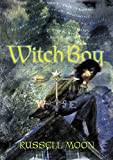


Estos 1 libros podrían gustarte también:

#1. Silver on the Tree (Silver on the Tree)


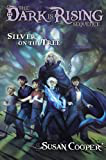

In [98]:
recomenda(1)

Qué libro te gusta?:
Far: A Novel


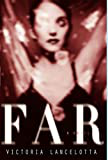


Estos 2 libros podrían gustarte también:
#1. Bitteres Geheimnis. Roman.


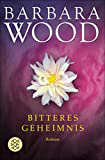

#2. Crystal Enchantments: A Complete Guide to Stones and Their Magical Properties (Crystals and New Age)


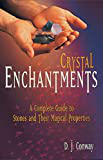

In [82]:
recomenda(2)

Qué libro te gusta?:
Thurber on Crime


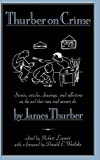


Estos 2 libros podrían gustarte también:

#1. Selected Essays (Penguin Classics)


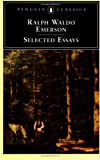

#2. The Best Christmas Ever


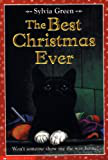

In [97]:
recomenda(2)